Found 825 images belonging to 2 classes.
Found 548 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 293s 11s/step - accuracy: 0.5390 - loss: 4.8649 - val_accuracy: 0.3960 - val_loss: 2.5318
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 281s 11s/step - accuracy: 0.5164 - loss: 2.1195 - val_accuracy: 0.4215 - val_loss: 1.3436
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 319s 11s/step - accuracy: 0.5459 - loss: 1.1922 - val_accuracy: 0.4453 - val_loss: 1.0543
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 317s 12s/step - accuracy: 0.5310 - loss: 1.0103 - val_accuracy: 0.4453 - val_loss: 1.0003
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 278s 11s/step - accuracy: 0.4834 - loss: 0.9734 - val_accuracy: 0.4434 - val_loss: 0.9195
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 331s 11s/step - accuracy: 0.5122 - loss: 0.9184 - val_accuracy: 0.4453 - val_loss: 0.9242
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 387s 15s/step - accuracy: 0.5081 - loss: 0.9042 - val_accuracy: 0.5383 - val_loss: 0.8763
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 351s 11s/step - accuracy: 0.5512 - loss: 0.8641 - val_accuracy: 0.5493 - val_

18/18 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.2332 - loss: 0.8301
Validation Accuracy: 44.71%
18/18 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step
Confusion Matrix:
 [[ 20 224]
 [ 70 234]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.22      0.08      0.12       244
    Abnormal       0.51      0.77      0.61       304

    accuracy                           0.46       548
   macro avg       0.37      0.43      0.37       548
weighted avg       0.38      0.46      0.39       548



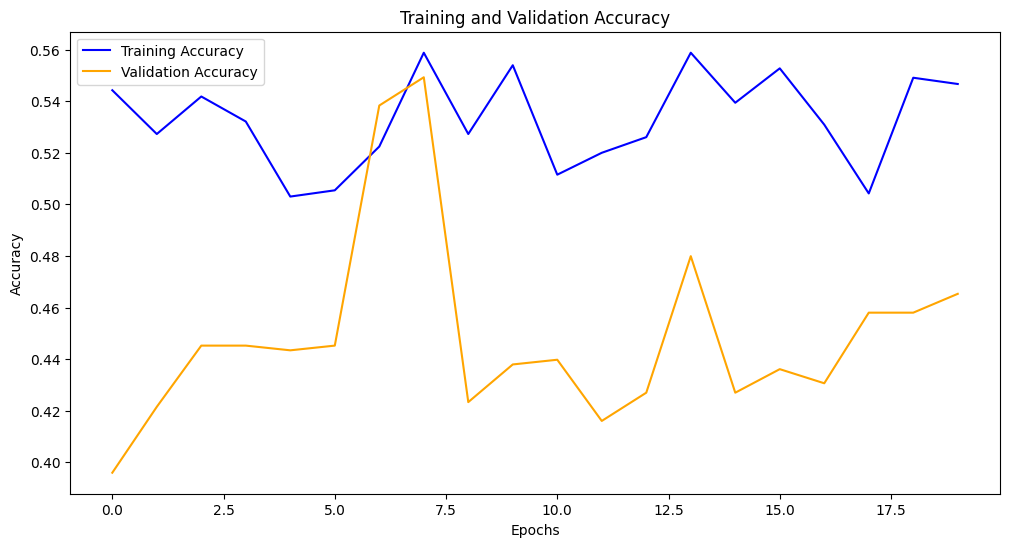

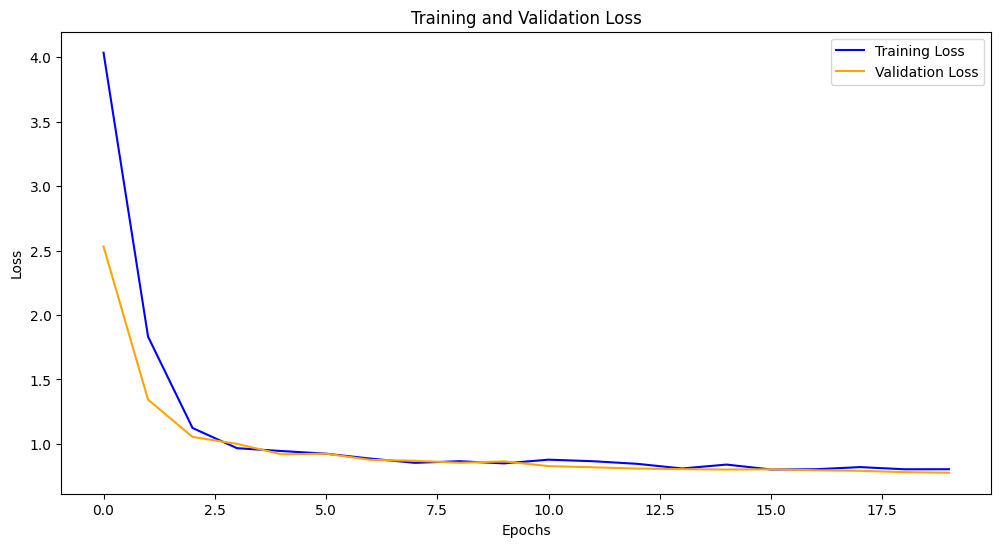

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras.applications import ResNet50
from keras import layers, models, optimizers
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Paths
dataset_dir = '/content/drive/MyDrive/Stethoscope project/Gayatri Shetty/dataset'  # Replace with your dataset directory

# Data Generators with Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4  # 60:40 train-validation split
)

# Training Data
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation Data
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Transfer Learning: ResNet50 as Base Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Build the Model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.BatchNormalization(),  # Batch normalization for stability
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Smaller learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the Model
history = model.fit(
train_generator,
    validation_data=val_generator,
    epochs=20,  # Adjust as needed
    callbacks=[early_stopping]
)

# Save the Model
model.save('heartbeat_cnn_model_improved.h5')

# Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
# Get predictions and true labels from validation generator
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal']))

# Plot Training and Validation Performance
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()